In [2]:
from parse import *
import networkx as nx
import solver_cynt as sc

In [3]:
path = "./inputs/small-161.in"
G = read_input_file(path)
T = sc.solve(G)

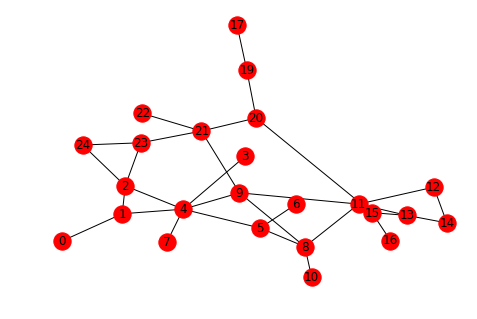

In [8]:
nx.draw(T, with_labels=True)

In [9]:
nx.is_connected(T)

True

In [10]:
nx.is_tree(T)

False

In [12]:
nx.number_of_edges(T)

30

In [13]:
nx.number_of_nodes(T)

24